In [ ]:
import nltk
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
! nvidia-smi

Tue May  3 15:55:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1) POS

In [ ]:
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

## الف

In [ ]:
nltk.corpus.treebank.tagged_sents(tagset='universal')[0]

[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET'),
 ('board', 'NOUN'),
 ('as', 'ADP'),
 ('a', 'DET'),
 ('nonexecutive', 'ADJ'),
 ('director', 'NOUN'),
 ('Nov.', 'NOUN'),
 ('29', 'NUM'),
 ('.', '.')]

In [ ]:
nltk.corpus.treebank.tagged_sents()[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

##  ب

In [ ]:
class DatasetManager:
    def __init__(self):
        dataset = nltk.corpus.treebank.tagged_sents(tagset='universal')
        train_set, test_set = train_test_split(dataset, test_size=0.15, random_state=42)
        train_set, dev_set = train_test_split(dataset, test_size=0.15, random_state=42)
        self.dataset = dict()
        self.dataset["x_train"] = [[d[0].lower() for d in data] for data in train_set]
        self.dataset["y_train"] = [[d[1] for d in data] for data in train_set]
        self.dataset["x_dev"] = [[d[0].lower() for d in data] for data in dev_set]
        self.dataset["y_dev"] = [[d[1] for d in data] for data in dev_set]
        self.dataset["x_test"] = [[d[0].lower() for d in data] for data in test_set]
        self.dataset["y_test"] = [[d[1] for d in data] for data in test_set]
        self.vocab = set([word for sentence in self.dataset["x_train"] for word in sentence])
        self.tags = set([tag for sentence in self.dataset["y_train"] for tag in sentence])

dataset_manager = DatasetManager()

In [ ]:
class ViterbiHMM:
    def __init__(self, dataset_manager: DatasetManager):
        self.dataset_manager = dataset_manager
        self.START = "<s>"
        self.UNKNOWN = "<unk>"
        # emission:   [word][tag]  -> p(w|t) = c(w,t) / c(t)
        self.emission_matrix = {w: {t: 0 for t in self.dataset_manager.tags} for w in self.dataset_manager.vocab}
        self.emission_matrix[self.UNKNOWN] = {t: 0 for t in self.dataset_manager.tags}
        # transition: [tag1][tag2] -> p(t2|t1) = c(t1, t2) / c(t1)
        self.transition_matrix = {t1: {t2: 0 for t2 in self.dataset_manager.tags} for t1 in self.dataset_manager.tags}
        self.transition_matrix[self.START] = {t: 0 for t in self.dataset_manager.tags}
        self.tag_count = dict()

    def __fill_tag_count(self):
        self.tag_count = {k: 0 for k in self.dataset_manager.tags}
        self.tag_count[self.START] = 0
        for sentence_tags in tqdm(self.dataset_manager.dataset["y_train"], desc="tag count"):
            for tag in sentence_tags:
                self.tag_count[tag] += 1
            self.tag_count[self.START] += 1

    def __fill_emission_matrix(self, smoothing=True):
        for data_idx in tqdm(range(len(self.dataset_manager.dataset["x_train"])), desc="emission"):
            words = self.dataset_manager.dataset["x_train"][data_idx]
            tags = self.dataset_manager.dataset["y_train"][data_idx]
            for word, tag in zip(words, tags):
                self.emission_matrix[word][tag] += 1
                
        for tag in self.dataset_manager.tags:
            for word in self.dataset_manager.vocab:
                if smoothing:
                    self.emission_matrix[word][tag] = (self.emission_matrix[word][tag] + 1) / (self.tag_count[tag] + len(self.dataset_manager.vocab))
                    self.emission_matrix[self.UNKNOWN][tag] = (0 + 1) / (self.tag_count[tag] + len(self.dataset_manager.vocab))
                else:
                    self.emission_matrix[word][tag] = self.emission_matrix[word][tag] / self.tag_count[tag]
                    self.emission_matrix[self.UNKNOWN][tag] = 0
        
    def __fill_transition_matrix(self, smoothing=True):
        for sentence_tags in tqdm(self.dataset_manager.dataset["y_train"], desc="transition"):
            for i in range(0, len(sentence_tags) - 1):
                tag1 = sentence_tags[i]
                tag2 = sentence_tags[i + 1]
                self.transition_matrix[tag1][tag2] += 1
                if i == 0:
                    self.transition_matrix[self.START][tag1] += 1
                    
        for tag1 in self.transition_matrix.keys():
            for tag2 in self.transition_matrix[tag1].keys():
                if smoothing:
                    self.transition_matrix[tag1][tag2] = (self.transition_matrix[tag1][tag2] + 1) / (self.tag_count[tag1] + len(self.dataset_manager.tags))
                else:
                    self.transition_matrix[tag1][tag2] = self.transition_matrix[tag1][tag2] / self.tag_count[tag1]

    def train(self):
        self.__fill_tag_count()
        self.__fill_transition_matrix()
        self.__fill_emission_matrix()

    def predict(self, sentence: list):  # Viterbi Algorithm
        viterbi = [{t: 0 for t in self.dataset_manager.tags} for w_idx in range(len(sentence))]
        back_pointer = [{t: 0 for t in self.dataset_manager.tags} for w_idx in range(len(sentence))]
        for tag in self.dataset_manager.tags:
            word = sentence[0]
            emission_prob = self.emission_matrix[self.UNKNOWN][tag] if word not in self.emission_matrix else self.emission_matrix[word][tag]
            viterbi[0][tag] = self.transition_matrix[self.START][tag] * emission_prob
        
        for word_idx in range(1, len(sentence)):
            word = sentence[word_idx]
            prev_word = sentence[word_idx - 1]
            for tag in self.dataset_manager.tags:
                viterbi[word_idx][tag] = 0
                for prev_tag in self.dataset_manager.tags:
                    emission_prob = self.emission_matrix[self.UNKNOWN][tag] if word not in self.emission_matrix else self.emission_matrix[word][tag]
                    new_viterbi = viterbi[word_idx - 1][prev_tag] * self.transition_matrix[prev_tag][tag] * emission_prob
                    if new_viterbi > viterbi[word_idx][tag]:
                        viterbi[word_idx][tag] = new_viterbi
                        back_pointer[word_idx][tag] = prev_tag

        last_tag_prob = 0
        for tag in self.dataset_manager.tags:
            if viterbi[-1][tag] >= last_tag_prob:
                last_tag_prob = viterbi[-1][tag]
                last_tag = tag
        
        best_tags = [last_tag]
        for word_idx in range(len(sentence) - 1, 0, -1):
            best_tags.append(back_pointer[word_idx][last_tag])
            last_tag = back_pointer[word_idx][last_tag]
        return list(reversed(best_tags))

    def evaluate(self):
        tp = 0
        total = 0
        for data_idx in tqdm(range(len(self.dataset_manager.dataset["x_test"]))):
            tags = self.predict(self.dataset_manager.dataset["x_test"][data_idx])
            for t_pred, t_true in zip(tags, self.dataset_manager.dataset["y_test"][data_idx]):
                total += 1
                if t_pred == t_true:
                    tp += 1
        return tp / total


viterbi = ViterbiHMM(dataset_manager)
viterbi.train()
viterbi.evaluate()

tag count:   0%|          | 0/3326 [00:00<?, ?it/s]

transition:   0%|          | 0/3326 [00:00<?, ?it/s]

emission:   0%|          | 0/3326 [00:00<?, ?it/s]

  0%|          | 0/588 [00:00<?, ?it/s]

0.9026159026159026

## ت

In [ ]:
# Errors
for idx in range(len(dataset_manager.dataset["x_test"])):
    sentence = dataset_manager.dataset["x_test"][idx]
    if len(sentence) < 8:
        pred = viterbi.predict(dataset_manager.dataset["x_test"][idx])
        true = dataset_manager.dataset["y_test"][idx]
        if pred != true:
            print(sentence)
            print("pred:", pred)
            print("true:", true)


['fundamentalists', 'jihad']
pred: ['DET', 'NOUN']
true: ['NOUN', 'NOUN']
['he', 'was', 'previously', 'vice', 'president', '.']
pred: ['PRON', 'VERB', 'DET', 'NOUN', 'NOUN', '.']
true: ['PRON', 'VERB', 'ADV', 'NOUN', 'NOUN', '.']
['such', 'is', 'hardly', 'the', 'case', '.']
pred: ['DET', 'VERB', 'ADP', 'DET', 'NOUN', '.']
true: ['ADJ', 'VERB', 'ADV', 'DET', 'NOUN', '.']
['heiwado', 'co', '.', '-lrb-', 'japan', '-rrb-', '--']
pred: ['DET', 'NOUN', '.', '.', 'NOUN', '.', '.']
true: ['NOUN', 'NOUN', '.', '.', 'NOUN', '.', '.']
['preston', 'g.', 'foster', 'birmingham', ',', 'ala', '.']
pred: ['DET', 'NOUN', 'NOUN', 'NOUN', '.', 'NOUN', '.']
true: ['NOUN', 'NOUN', 'NOUN', 'NOUN', '.', 'NOUN', '.']
['mortgage-backed', 'issues']
pred: ['DET', 'NOUN']
true: ['NOUN', 'NOUN']
['it', 'rose', '7\\/8', 'to', '18', '1\\/4', '.']
pred: ['PRON', 'VERB', 'X', 'PRT', 'NUM', 'NUM', '.']
true: ['PRON', 'VERB', 'NUM', 'PRT', 'NUM', 'NUM', '.']
['champagne', 'and', 'dessert', 'followed', '.']
pred: ['NOUN',

In [ ]:
"dessert" in dataset_manager.vocab

False

# ج
RNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns

In [ ]:
class Trainer:
    def __init__(self, dataset_manager: DatasetManager, units=64, rnn="SimpleRNN") -> None:
        self.dataset_manager = dataset_manager
        self.rnn = rnn
        self.tokenizer = Tokenizer(num_words=15000, oov_token="[UNK]")
        self.tokenizer.fit_on_texts(dataset_manager.dataset["x_train"])
        self.tokenized_x_train = pad_sequences(self.tokenizer.texts_to_sequences(dataset_manager.dataset["x_train"]), maxlen=100, padding="post")
        self.tokenized_x_dev = pad_sequences(self.tokenizer.texts_to_sequences(dataset_manager.dataset["x_dev"]), maxlen=100, padding="post")
        self.tokenized_x_test = pad_sequences(self.tokenizer.texts_to_sequences(dataset_manager.dataset["x_test"]), maxlen=100, padding="post")

        self.tag_tokenizer = Tokenizer()
        self.tag_tokenizer.fit_on_texts(dataset_manager.dataset["y_train"])
        self.tokenized_y_train = to_categorical(pad_sequences(self.tag_tokenizer.texts_to_sequences(dataset_manager.dataset["y_train"]), maxlen=100, padding="post"), num_classes = len(self.dataset_manager.tags) + 1)
        self.tokenized_y_dev = to_categorical(pad_sequences(self.tag_tokenizer.texts_to_sequences(dataset_manager.dataset["y_dev"]), maxlen=100, padding="post"), num_classes = len(self.dataset_manager.tags) + 1)
        self.tokenized_y_test = to_categorical(pad_sequences(self.tag_tokenizer.texts_to_sequences(dataset_manager.dataset["y_test"]), maxlen=100, padding="post"), num_classes = len(self.dataset_manager.tags) + 1)      

        self.model = self.build_model(units)
        self.history = None

    def build_model(self, units):
        rnn_map = {
            "SimpleRNN": tf.keras.layers.SimpleRNN(units, return_sequences=True),
            "GRU": tf.keras.layers.GRU(units, return_sequences=True),
            "LSTM": tf.keras.layers.LSTM(units, return_sequences=True),
        }
        model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=15000, output_dim=32, input_length=100),
            rnn_map[self.rnn],
            tf.keras.layers.TimeDistributed(
                tf.keras.layers.Dense(len(self.dataset_manager.tags) + 1, 
                                      activation='softmax')
            )
        ])
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model
    
    def train(self, batch_size=128, epochs=50):
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            verbose=1,
            patience=5,
            mode='min',
            restore_best_weights=True
        )
        self.history = self.model.fit(
            self.tokenized_x_train, self.tokenized_y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(self.tokenized_x_dev, self.tokenized_y_dev),
            callbacks=[early_stopping],
        )
    
    def plot_history(self):
        fig = plt.figure(figsize=(12, 4))
        metrics = ['loss', 'accuracy']
        for n, metric in enumerate(metrics):
            plt.subplot(1, 2, n+1)
            plt.plot(self.history.epoch, self.history.history[metric], label='Train')
            plt.plot(self.history.epoch, self.history.history[f"val_{metric}"], linestyle="--", label='Validation')
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.title(metric)
        plt.legend()
        plt.show()

    def evaluate(self):
        [test_loss, test_acc] = self.model.evaluate(self.tokenized_x_test, self.tokenized_y_test)
        print("Test Loss:", test_loss, "Test Accuracy (w/ padding):", test_acc)
        def flatten(t):
            return [item for sublist in t for item in sublist]
        test_preds = np.argmax(self.model.predict(self.tokenized_x_test), axis=-1)
        test_preds = flatten([test_preds[i][:len(dataset_manager.dataset["x_test"][i])] for i in range(len(test_preds))])
        y_test = np.argmax(self.tokenized_y_test, axis=-1)
        y_test = flatten([y_test[i][:len(dataset_manager.dataset["y_test"][i])] for i in range(len(y_test))])
        self.plot_cm(y_test, test_preds)
        print("Test Accuracy (w/o padding):", accuracy_score(y_test, test_preds))
    
    def plot_cm(self, y_true, preds):
        cm = confusion_matrix(y_true, preds)
        plt.figure(figsize=(7, 5))
        ax = sns.heatmap(cm, annot=True, fmt="d")
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

### UNITS=4 ###
Epoch 1/50
52/52 [==============================] - 7s 110ms/step - loss: 2.3775 - accuracy: 0.1779 - val_loss: 2.1567 - val_accuracy: 0.7665
Epoch 2/50
52/52 [==============================] - 5s 101ms/step - loss: 1.8950 - accuracy: 0.7819 - val_loss: 1.6407 - val_accuracy: 0.7835
Epoch 3/50
52/52 [==============================] - 5s 91ms/step - loss: 1.4271 - accuracy: 0.7999 - val_loss: 1.2549 - val_accuracy: 0.8037
Epoch 4/50
52/52 [==============================] - 5s 98ms/step - loss: 1.1194 - accuracy: 0.8165 - val_loss: 1.0239 - val_accuracy: 0.8156
Epoch 5/50
52/52 [==============================] - 5s 100ms/step - loss: 0.9347 - accuracy: 0.8209 - val_loss: 0.8808 - val_accuracy: 0.8159
Epoch 6/50
52/52 [==============================] - 5s 95ms/step - loss: 0.8154 - accuracy: 0.8215 - val_loss: 0.7840 - val_accuracy: 0.8169
Epoch 7/50
52/52 [==============================] - 5s 93ms/step - loss: 0.7315 - accuracy: 0.8231 - val_loss: 0.7129 - val_accuracy: 0

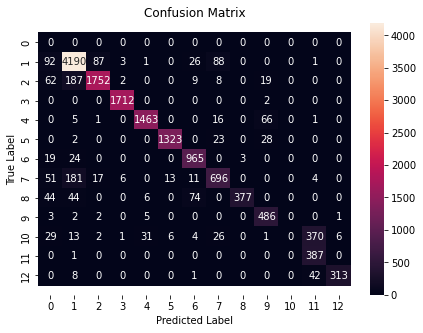

Test Accuracy (w/o padding): 0.8847448847448848


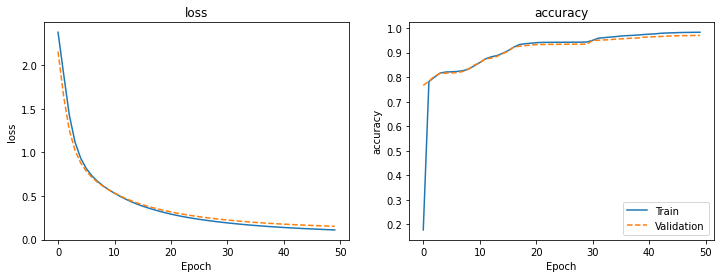

### UNITS=16 ###
Epoch 1/50
52/52 [==============================] - 6s 92ms/step - loss: 1.7968 - accuracy: 0.6180 - val_loss: 1.0798 - val_accuracy: 0.7421
Epoch 2/50
52/52 [==============================] - 5s 90ms/step - loss: 0.8251 - accuracy: 0.7762 - val_loss: 0.7061 - val_accuracy: 0.8008
Epoch 3/50
52/52 [==============================] - 5s 92ms/step - loss: 0.6276 - accuracy: 0.8306 - val_loss: 0.5995 - val_accuracy: 0.8307
Epoch 4/50
52/52 [==============================] - 5s 97ms/step - loss: 0.5479 - accuracy: 0.8405 - val_loss: 0.5368 - val_accuracy: 0.8462
Epoch 5/50
52/52 [==============================] - 5s 97ms/step - loss: 0.4895 - accuracy: 0.8606 - val_loss: 0.4805 - val_accuracy: 0.8671
Epoch 6/50
52/52 [==============================] - 5s 97ms/step - loss: 0.4340 - accuracy: 0.8822 - val_loss: 0.4259 - val_accuracy: 0.8877
Epoch 7/50
52/52 [==============================] - 5s 96ms/step - loss: 0.3799 - accuracy: 0.9029 - val_loss: 0.3733 - val_accuracy: 0.9

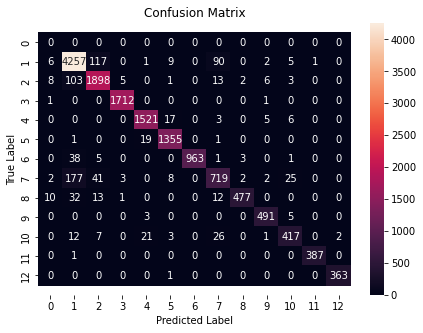

Test Accuracy (w/o padding): 0.9427609427609428


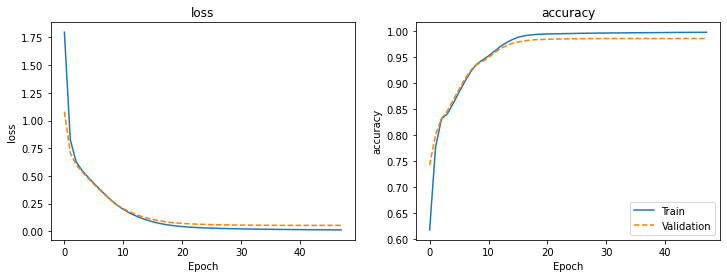

### UNITS=64 ###
Epoch 1/50
52/52 [==============================] - 6s 95ms/step - loss: 1.3081 - accuracy: 0.7046 - val_loss: 0.8956 - val_accuracy: 0.7528
Epoch 2/50
52/52 [==============================] - 5s 92ms/step - loss: 0.7004 - accuracy: 0.7914 - val_loss: 0.6449 - val_accuracy: 0.8076
Epoch 3/50
52/52 [==============================] - 5s 90ms/step - loss: 0.5785 - accuracy: 0.8225 - val_loss: 0.5632 - val_accuracy: 0.8264
Epoch 4/50
52/52 [==============================] - 5s 93ms/step - loss: 0.5177 - accuracy: 0.8374 - val_loss: 0.5115 - val_accuracy: 0.8416
Epoch 5/50
52/52 [==============================] - 5s 89ms/step - loss: 0.4606 - accuracy: 0.8599 - val_loss: 0.4491 - val_accuracy: 0.8692
Epoch 6/50
52/52 [==============================] - 5s 93ms/step - loss: 0.3908 - accuracy: 0.8927 - val_loss: 0.3725 - val_accuracy: 0.9046
Epoch 7/50
52/52 [==============================] - 5s 90ms/step - loss: 0.3119 - accuracy: 0.9260 - val_loss: 0.2937 - val_accuracy: 0.9

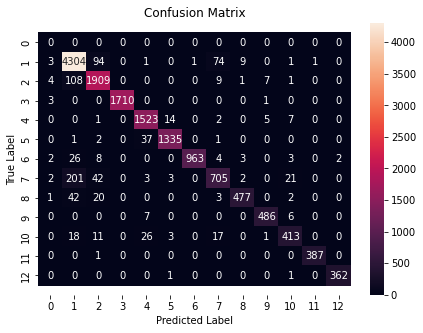

Test Accuracy (w/o padding): 0.9436674436674437


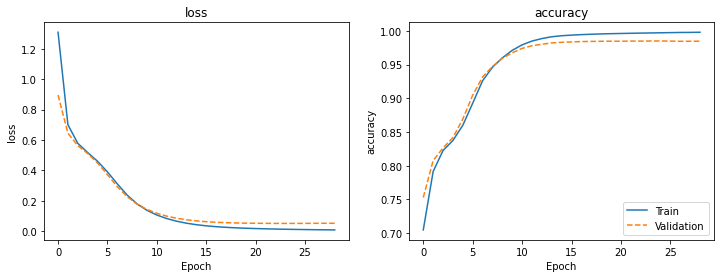

In [ ]:
for units in [4, 16, 64]:
    print(f"### UNITS={units} ###")
    trainer = Trainer(dataset_manager, units=units)
    trainer.train(batch_size=64, epochs=50)
    print(trainer.model.summary())
    trainer.evaluate()
    trainer.plot_history()

# ح

### UNITS=4 ###
Epoch 1/50
52/52 [==============================] - 6s 23ms/step - loss: 2.4141 - accuracy: 0.6579 - val_loss: 2.1970 - val_accuracy: 0.7470
Epoch 2/50
52/52 [==============================] - 0s 9ms/step - loss: 1.8596 - accuracy: 0.7597 - val_loss: 1.5071 - val_accuracy: 0.7651
Epoch 3/50
52/52 [==============================] - 0s 9ms/step - loss: 1.2672 - accuracy: 0.7814 - val_loss: 1.1022 - val_accuracy: 0.7870
Epoch 4/50
52/52 [==============================] - 0s 9ms/step - loss: 0.9866 - accuracy: 0.7999 - val_loss: 0.9126 - val_accuracy: 0.8020
Epoch 5/50
52/52 [==============================] - 0s 8ms/step - loss: 0.8361 - accuracy: 0.8106 - val_loss: 0.7950 - val_accuracy: 0.8094
Epoch 6/50
52/52 [==============================] - 0s 8ms/step - loss: 0.7361 - accuracy: 0.8169 - val_loss: 0.7110 - val_accuracy: 0.8164
Epoch 7/50
52/52 [==============================] - 0s 9ms/step - loss: 0.6611 - accuracy: 0.8281 - val_loss: 0.6450 - val_accuracy: 0.8385
Epo

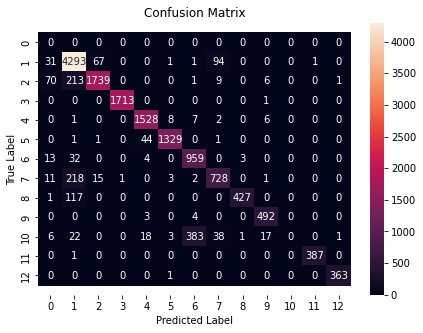

Test Accuracy (w/o padding): 0.9037814037814038


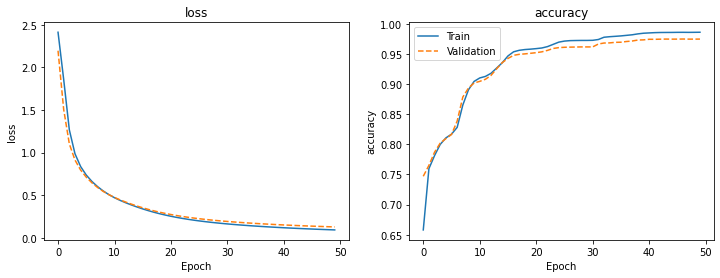

### UNITS=16 ###
Epoch 1/50
52/52 [==============================] - 2s 17ms/step - loss: 2.1148 - accuracy: 0.6752 - val_loss: 1.2511 - val_accuracy: 0.7373
Epoch 2/50
52/52 [==============================] - 0s 9ms/step - loss: 0.7973 - accuracy: 0.7786 - val_loss: 0.6857 - val_accuracy: 0.8354
Epoch 3/50
52/52 [==============================] - 0s 8ms/step - loss: 0.6376 - accuracy: 0.8507 - val_loss: 0.6271 - val_accuracy: 0.8602
Epoch 4/50
52/52 [==============================] - 0s 9ms/step - loss: 0.5742 - accuracy: 0.8802 - val_loss: 0.5517 - val_accuracy: 0.8880
Epoch 5/50
52/52 [==============================] - 0s 9ms/step - loss: 0.4838 - accuracy: 0.9105 - val_loss: 0.4503 - val_accuracy: 0.9144
Epoch 6/50
52/52 [==============================] - 0s 9ms/step - loss: 0.3851 - accuracy: 0.9305 - val_loss: 0.3581 - val_accuracy: 0.9325
Epoch 7/50
52/52 [==============================] - 0s 9ms/step - loss: 0.3015 - accuracy: 0.9467 - val_loss: 0.2837 - val_accuracy: 0.9466
Ep

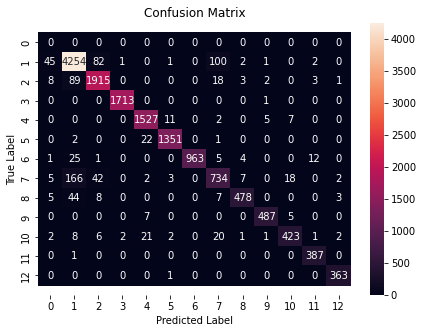

Test Accuracy (w/o padding): 0.945027195027195


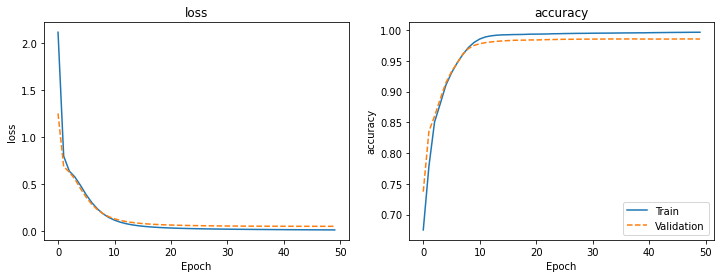

### UNITS=64 ###
Epoch 1/50
52/52 [==============================] - 2s 18ms/step - loss: 1.4077 - accuracy: 0.7171 - val_loss: 0.7129 - val_accuracy: 0.7443
Epoch 2/50
52/52 [==============================] - 0s 9ms/step - loss: 0.6570 - accuracy: 0.7860 - val_loss: 0.6531 - val_accuracy: 0.8009
Epoch 3/50
52/52 [==============================] - 0s 9ms/step - loss: 0.6158 - accuracy: 0.8147 - val_loss: 0.6088 - val_accuracy: 0.8131
Epoch 4/50
52/52 [==============================] - 0s 9ms/step - loss: 0.5565 - accuracy: 0.8208 - val_loss: 0.5376 - val_accuracy: 0.8241
Epoch 5/50
52/52 [==============================] - 0s 9ms/step - loss: 0.4822 - accuracy: 0.8417 - val_loss: 0.4487 - val_accuracy: 0.8557
Epoch 6/50
52/52 [==============================] - 0s 9ms/step - loss: 0.3683 - accuracy: 0.8940 - val_loss: 0.3150 - val_accuracy: 0.9235
Epoch 7/50
52/52 [==============================] - 0s 9ms/step - loss: 0.2400 - accuracy: 0.9396 - val_loss: 0.2030 - val_accuracy: 0.9473
Ep

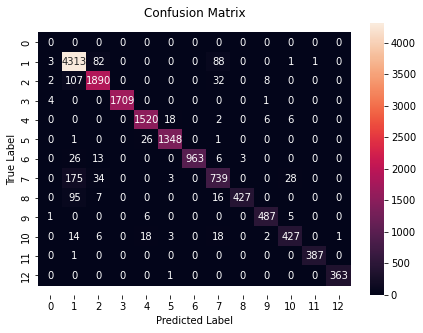

Test Accuracy (w/o padding): 0.9436026936026936


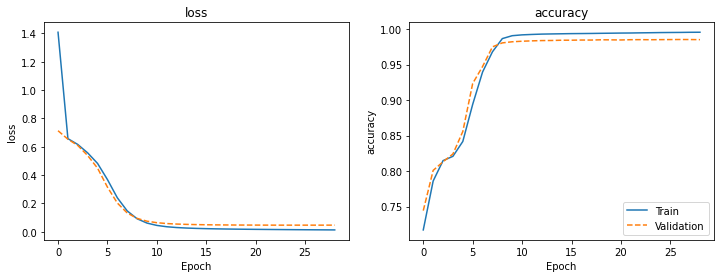

In [ ]:
# GRU
for units in [4, 16, 64]:
    print(f"### UNITS={units} ###")
    trainer = Trainer(dataset_manager, units=units, rnn="GRU")
    trainer.train(batch_size=64, epochs=50)
    print(trainer.model.summary())
    trainer.evaluate()
    trainer.plot_history()

### UNITS=4 ###
Epoch 1/100
52/52 [==============================] - 2s 17ms/step - loss: 2.3015 - accuracy: 0.6792 - val_loss: 1.8851 - val_accuracy: 0.7373
Epoch 2/100
52/52 [==============================] - 0s 9ms/step - loss: 1.5401 - accuracy: 0.7454 - val_loss: 1.2996 - val_accuracy: 0.7426
Epoch 3/100
52/52 [==============================] - 0s 9ms/step - loss: 1.1299 - accuracy: 0.7607 - val_loss: 1.0136 - val_accuracy: 0.7622
Epoch 4/100
52/52 [==============================] - 0s 9ms/step - loss: 0.9163 - accuracy: 0.7847 - val_loss: 0.8657 - val_accuracy: 0.7903
Epoch 5/100
52/52 [==============================] - 0s 9ms/step - loss: 0.8045 - accuracy: 0.8055 - val_loss: 0.7834 - val_accuracy: 0.8057
Epoch 6/100
52/52 [==============================] - 0s 9ms/step - loss: 0.7375 - accuracy: 0.8141 - val_loss: 0.7293 - val_accuracy: 0.8103
Epoch 7/100
52/52 [==============================] - 0s 9ms/step - loss: 0.6906 - accuracy: 0.8167 - val_loss: 0.6889 - val_accuracy: 0.8

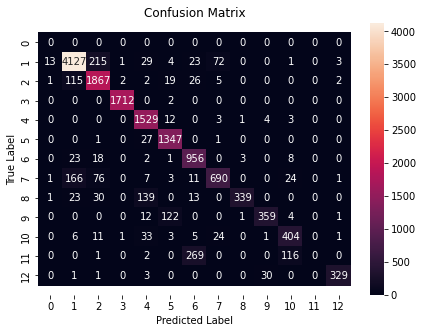

Test Accuracy (w/o padding): 0.8844211344211345


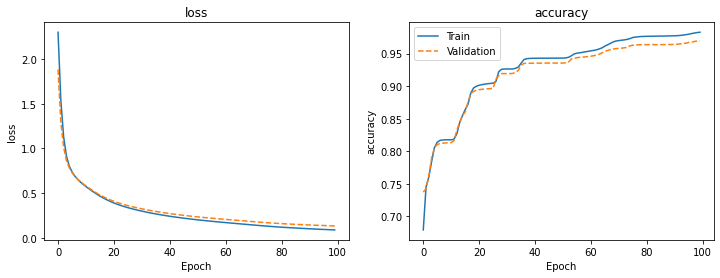

### UNITS=16 ###
Epoch 1/100
52/52 [==============================] - 3s 18ms/step - loss: 1.8700 - accuracy: 0.7186 - val_loss: 1.1673 - val_accuracy: 0.7373
Epoch 2/100
52/52 [==============================] - 0s 9ms/step - loss: 0.9054 - accuracy: 0.7466 - val_loss: 0.7708 - val_accuracy: 0.7430
Epoch 3/100
52/52 [==============================] - 0s 9ms/step - loss: 0.7050 - accuracy: 0.7639 - val_loss: 0.6966 - val_accuracy: 0.7677
Epoch 4/100
52/52 [==============================] - 0s 9ms/step - loss: 0.6557 - accuracy: 0.7902 - val_loss: 0.6605 - val_accuracy: 0.7967
Epoch 5/100
52/52 [==============================] - 0s 9ms/step - loss: 0.6250 - accuracy: 0.8133 - val_loss: 0.6287 - val_accuracy: 0.8132
Epoch 6/100
52/52 [==============================] - 0s 9ms/step - loss: 0.5976 - accuracy: 0.8183 - val_loss: 0.6025 - val_accuracy: 0.8153
Epoch 7/100
52/52 [==============================] - 0s 9ms/step - loss: 0.5730 - accuracy: 0.8212 - val_loss: 0.5779 - val_accuracy: 0.

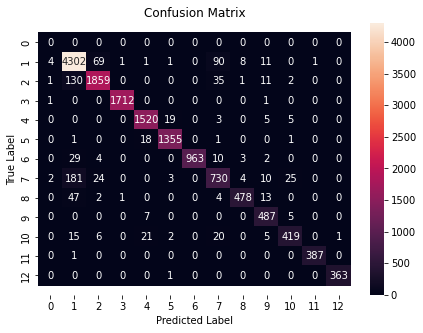

Test Accuracy (w/o padding): 0.9437321937321937


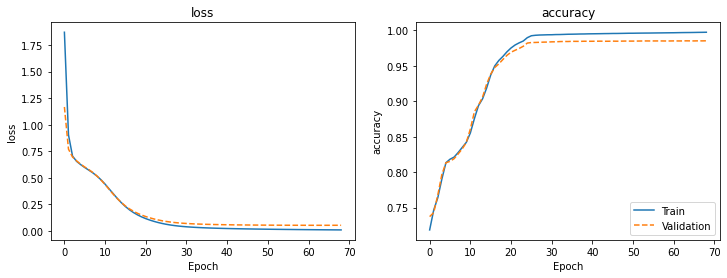

### UNITS=64 ###
Epoch 1/100
52/52 [==============================] - 3s 19ms/step - loss: 1.2866 - accuracy: 0.7185 - val_loss: 0.7832 - val_accuracy: 0.7484
Epoch 2/100
52/52 [==============================] - 0s 10ms/step - loss: 0.7051 - accuracy: 0.7634 - val_loss: 0.6859 - val_accuracy: 0.7601
Epoch 3/100
52/52 [==============================] - 1s 10ms/step - loss: 0.6442 - accuracy: 0.7919 - val_loss: 0.6404 - val_accuracy: 0.8131
Epoch 4/100
52/52 [==============================] - 1s 10ms/step - loss: 0.6017 - accuracy: 0.8167 - val_loss: 0.6030 - val_accuracy: 0.8141
Epoch 5/100
52/52 [==============================] - 1s 10ms/step - loss: 0.5720 - accuracy: 0.8225 - val_loss: 0.5803 - val_accuracy: 0.8217
Epoch 6/100
52/52 [==============================] - 1s 10ms/step - loss: 0.5512 - accuracy: 0.8262 - val_loss: 0.5603 - val_accuracy: 0.8226
Epoch 7/100
52/52 [==============================] - 1s 10ms/step - loss: 0.5288 - accuracy: 0.8275 - val_loss: 0.5330 - val_accura

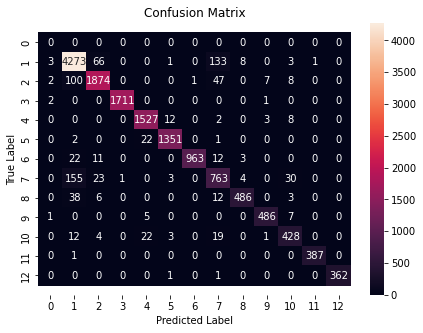

Test Accuracy (w/o padding): 0.9460631960631961


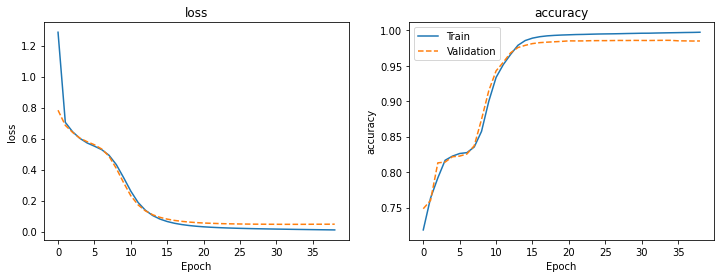

In [ ]:
# LSTM
for units in [4, 16, 64]:
    print(f"### UNITS={units} ###")
    trainer = Trainer(dataset_manager, units=units, rnn="LSTM")
    trainer.train(batch_size=64, epochs=100)
    print(trainer.model.summary())
    trainer.evaluate()
    trainer.plot_history()

# 2) NER

In [1]:
import nltk
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from nltk.chunk import conlltags2tree, tree2conlltags
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

In [2]:
nltk.download('treebank')
nltk.download('universal_tagset')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

## الف

In [29]:
class DatasetManager:
    def __init__(self):
        dataset = nltk.corpus.treebank.tagged_sents()
        dataset = [tree2conlltags(nltk.ne_chunk(d)) for d in dataset]
        train_set, test_set = train_test_split(dataset, test_size=0.35, random_state=41)
        train_set, dev_set = train_test_split(dataset, test_size=0.01, random_state=41)
        self.dataset = dict()
        self.dataset["x_train"] = [[d[0].lower() for d in data] for data in train_set]
        self.dataset["y_train"] = [[d[2] for d in data] for data in train_set]
        self.dataset["x_dev"] = [[d[0].lower() for d in data] for data in dev_set]
        self.dataset["y_dev"] = [[d[2] for d in data] for data in dev_set]
        self.dataset["x_test"] = [[d[0].lower() for d in data] for data in test_set]
        self.dataset["y_test"] = [[d[2] for d in data] for data in test_set]
        self.vocab = set([word for sentence in self.dataset["x_train"] for word in sentence])
        self.tags = set([tag for sentence in self.dataset["y_train"] for tag in sentence])

dataset_manager = DatasetManager()

In [34]:
print(dataset_manager.dataset["x_train"][1])
print(dataset_manager.dataset["y_train"][1])

['the', 'philadelphia', 'fed', ',', 'for', 'instance', ',', 'reported', 'that', 'manufacturing', 'activity', '``', 'continues', '*-1', 'to', 'decline', "''", 'for', 'the', 'fourth', 'month', 'in', 'a', 'row', '.']
['O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [32]:
class NERViterbiHMM:
    def __init__(self, dataset_manager: DatasetManager):
        self.dataset_manager = dataset_manager
        self.START = "<s>"
        self.UNKNOWN = "<unk>"
        # emission:   [word][tag]  -> p(w|t) = c(w,t) / c(t)
        self.emission_matrix = {w: {t: 0 for t in self.dataset_manager.tags} for w in self.dataset_manager.vocab}
        self.emission_matrix[self.UNKNOWN] = {t: 0 for t in self.dataset_manager.tags}
        # transition: [tag1][tag2] -> p(t2|t1) = c(t1, t2) / c(t1)
        self.transition_matrix = {t1: {t2: 0 for t2 in self.dataset_manager.tags} for t1 in self.dataset_manager.tags}
        self.transition_matrix[self.START] = {t: 0 for t in self.dataset_manager.tags}
        self.tag_count = dict()

    def __fill_tag_count(self):
        self.tag_count = {k: 0 for k in self.dataset_manager.tags}
        self.tag_count[self.START] = 0
        for sentence_tags in tqdm(self.dataset_manager.dataset["y_train"], desc="tag count"):
            for tag in sentence_tags:
                self.tag_count[tag] += 1
            self.tag_count[self.START] += 1

    def __fill_emission_matrix(self, smoothing=True):
        for data_idx in tqdm(range(len(self.dataset_manager.dataset["x_train"])), desc="emission"):
            words = self.dataset_manager.dataset["x_train"][data_idx]
            tags = self.dataset_manager.dataset["y_train"][data_idx]
            for word, tag in zip(words, tags):
                self.emission_matrix[word][tag] += 1
                
        for tag in self.dataset_manager.tags:
            for word in self.dataset_manager.vocab:
                if smoothing:
                    self.emission_matrix[word][tag] = (self.emission_matrix[word][tag] + 1) / (self.tag_count[tag] + len(self.dataset_manager.vocab))
                    self.emission_matrix[self.UNKNOWN][tag] = (0 + 1) / (self.tag_count[tag] + len(self.dataset_manager.vocab))
                else:
                    self.emission_matrix[word][tag] = self.emission_matrix[word][tag] / self.tag_count[tag]
                    self.emission_matrix[self.UNKNOWN][tag] = 0
        
    def __fill_transition_matrix(self, smoothing=True):
        for sentence_tags in tqdm(self.dataset_manager.dataset["y_train"], desc="transition"):
            for i in range(0, len(sentence_tags) - 1):
                tag1 = sentence_tags[i]
                tag2 = sentence_tags[i + 1]
                self.transition_matrix[tag1][tag2] += 1
                if i == 0:
                    self.transition_matrix[self.START][tag1] += 1
        
        for tag1 in self.transition_matrix.keys():
            for tag2 in self.transition_matrix[tag1].keys():
                if smoothing:
                    self.transition_matrix[tag1][tag2] = (self.transition_matrix[tag1][tag2] + 1) / (self.tag_count[tag1] + len(self.dataset_manager.tags))
                else:
                    self.transition_matrix[tag1][tag2] = self.transition_matrix[tag1][tag2] / self.tag_count[tag1]

        for tag1 in self.transition_matrix.keys():
            for tag2 in self.transition_matrix[tag1].keys():
                if "I-" in tag1 and "B-" in tag2 and tag1[2:] == tag2[2:]:
                    self.transition_matrix[tag1][tag2] = 0
                if "O" == tag1 and "I-" in tag2:
                    self.transition_matrix[tag1][tag2] = 0
                if "I-" in tag1 and "I-" in tag2 and tag1[2:] != tag2[2:]:
                    self.transition_matrix[tag1][tag2] = 0

    def train(self):
        self.__fill_tag_count()
        self.__fill_transition_matrix()
        self.__fill_emission_matrix()

    def predict(self, sentence: list):  # Viterbi Algorithm
        viterbi = [{t: 0 for t in self.dataset_manager.tags} for w_idx in range(len(sentence))]
        back_pointer = [{t: 0 for t in self.dataset_manager.tags} for w_idx in range(len(sentence))]
        for tag in self.dataset_manager.tags:
            word = sentence[0]
            emission_prob = self.emission_matrix[self.UNKNOWN][tag] if word not in self.emission_matrix else self.emission_matrix[word][tag]
            viterbi[0][tag] = self.transition_matrix[self.START][tag] * emission_prob
        
        for word_idx in range(1, len(sentence)):
            word = sentence[word_idx]
            prev_word = sentence[word_idx - 1]
            for tag in self.dataset_manager.tags:
                viterbi[word_idx][tag] = 0
                for prev_tag in self.dataset_manager.tags:
                    emission_prob = self.emission_matrix[self.UNKNOWN][tag] if word not in self.emission_matrix else self.emission_matrix[word][tag]
                    new_viterbi = viterbi[word_idx - 1][prev_tag] * self.transition_matrix[prev_tag][tag] * emission_prob
                    if new_viterbi > viterbi[word_idx][tag]:
                        viterbi[word_idx][tag] = new_viterbi
                        back_pointer[word_idx][tag] = prev_tag

        last_tag_prob = 0
        for tag in self.dataset_manager.tags:
            if viterbi[-1][tag] >= last_tag_prob:
                last_tag_prob = viterbi[-1][tag]
                last_tag = tag
        
        best_tags = [last_tag]

        try:
            for word_idx in range(len(sentence) - 1, 0, -1):
                best_tags.append(back_pointer[word_idx][last_tag])
                last_tag = back_pointer[word_idx][last_tag]
        except Exception as e:
            pass
        return list(reversed(best_tags))

    def evaluate(self):
        tp = 0
        total = 0
        preds, trues = [], []
        for data_idx in tqdm(range(len(self.dataset_manager.dataset["x_test"]))):
            tags = self.predict(self.dataset_manager.dataset["x_test"][data_idx])
            for t_pred, t_true in zip(tags, self.dataset_manager.dataset["y_test"][data_idx]):
                preds.append(t_pred)
                trues.append(t_true)
                total += 1
                if t_pred == t_true:
                    tp += 1
        print(classification_report(trues, preds))
        return tp / total


viterbi = NERViterbiHMM(dataset_manager)
viterbi.train()
viterbi.evaluate()

tag count:   0%|          | 0/3874 [00:00<?, ?it/s]

transition:   0%|          | 0/3874 [00:00<?, ?it/s]

emission:   0%|          | 0/3874 [00:00<?, ?it/s]

  0%|          | 0/1370 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

             0       0.00      0.00      0.00         0
    B-FACILITY       0.75      0.60      0.67        15
         B-GPE       0.92      0.58      0.71       651
         B-GSP       0.00      0.00      0.00        10
    B-LOCATION       0.00      0.00      0.00        10
B-ORGANIZATION       0.84      0.25      0.39       564
      B-PERSON       0.91      0.58      0.71       720
    I-FACILITY       0.73      0.73      0.73        15
         I-GPE       0.90      0.78      0.84        79
    I-LOCATION       0.00      0.00      0.00         8
I-ORGANIZATION       0.75      0.38      0.50       338
      I-PERSON       0.73      0.81      0.77       458
             O       0.97      1.00      0.98     32304

      accuracy                           0.96     35172
     macro avg       0.58      0.44      0.48     35172
  weighted avg       0.96      0.96      0.95     35172



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

0.9590867735698851

In [ ]:
df_dict = dict()
for k in dataset_manager.tags:
    df_dict[k] = [viterbi.transition_matrix[k][i] for i in dataset_manager.tags]

pd.DataFrame.from_dict(df_dict, orient='index', columns=dataset_manager.tags)

,B-FACILITY,I-PERSON,B-PERSON,I-ORGANIZATION,I-GPE,B-GPE,B-LOCATION,B-ORGANIZATION,I-FACILITY,O
B-FACILITY,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.545455,0.090909
I-PERSON,0.021739,0.086957,0.000000,0.000000,0.000000,0.021739,0.021739,0.021739,0.000000,0.717391
B-PERSON,0.006329,0.215190,0.025316,0.006329,0.006329,0.006329,0.006329,0.088608,0.006329,0.632911
I-ORGANIZATION,0.006061,0.000000,0.006061,0.193939,0.000000,0.006061,0.006061,0.000000,0.000000,0.751515
I-GPE,0.011765,0.000000,0.011765,0.000000,0.023529,0.000000,0.011765,0.011765,0.000000,0.882353
B-GPE,0.001603,0.001603,0.001603,0.001603,0.120192,0.003205,0.001603,0.068910,0.001603,0.798077
B-LOCATION,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.307692
B-ORGANIZATION,0.002577,0.002577,0.002577,0.322165,0.002577,0.002577,0.002577,0.012887,0.002577,0.646907
I-FACILITY,0.000000,0.000000,0.047619,0.000000,0.000000,0.047619,0.047619,0.047619,0.047619,0.571429
O,0.000155,0.000000,0.001301,0.000000,0.000000,0.006049,0.000048,0.003747,0.000000,0.948968
